# **LinkedIn Job Posting Project**
## **Description**

This project leverages a comprehensive dataset featuring over 124,000 job postings on LinkedIn from 2023 and 2024, capturing a wide array of details related to job listings, company information, and employment dynamics.

---
## **Data Introduction**
### **1. Job Postings (`posting.csv`)**

This file contains detailed information about each job posting, with the following attributes:
```
['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type']
```
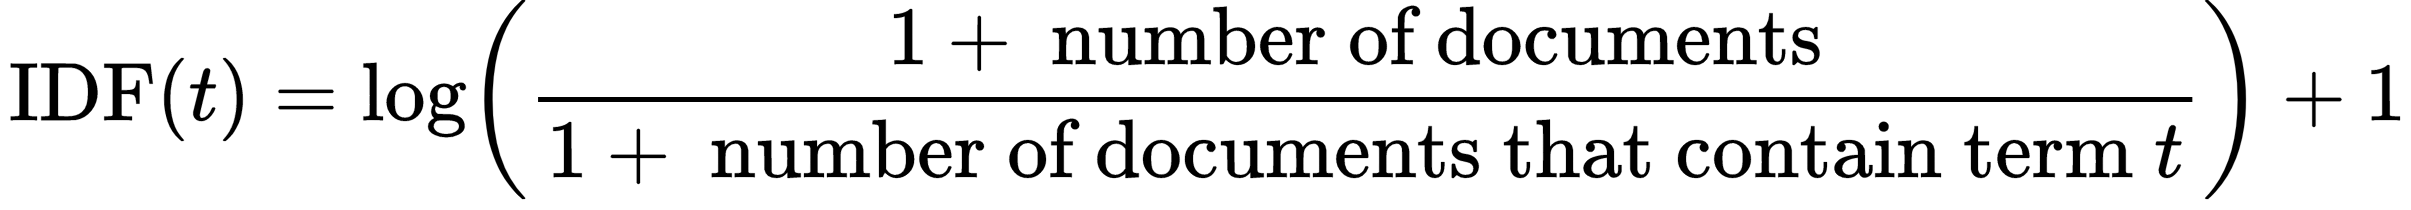
### **2. Mapping Files**

#### **a. Industries (`industries.csv`)**

Maps industry IDs to names:
```
['industry_id', 'industry_name']
```

#### **b. Skills (`skills.csv`)**

Contains abbreviations and full names of skills:
```
['skill_abr', 'skill_name']
```

### **3. Job-Related Data**

#### **a. Benefits (`benefits.csv`)**

Details the benefits associated with each job:
```
['job_id', 'inferred', 'type']
```

#### **b. Job Industries (`job_industries.csv`)**

Links jobs to industries. Merge with `industries.csv` for full details:
```
['job_id', 'industry_id']
```

#### **c. Job Skills (`job_skills.csv`)**

Associates skills with job postings. Merge with `skills.csv` for descriptive names:
```
['job_id', 'skill_abr']
```

#### **d. Salaries (`salaries.csv`)**

Outlines salary details for each posting. No merge required:
```
['salary_id', 'job_id', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 'currency', 'compensation_type']
```

### **4. Company Data (Optional)**

#### **a. Companies (`companies.csv`)**

Comprehensive details about each company:
```
['company_id', 'name', 'description', 'company_size', 'state', 'country', 'city', 'zip_code', 'address', 'url']
```

#### **b. Company Industries (`company_industries.csv`)**

Maps companies to industries:
```
['company_id', 'industry']
```

#### **c. Company Specialities (`company_specialities.csv`)**

Lists specialities of companies:
```
['company_id', 'speciality']
```

#### **d. Employee Counts (`employee_counts.csv`)**

Tracks employee and follower counts over time:
```
['company_id', 'employee_count', 'follower_count', 'time_recorded']
```


In [ ]:
# @title **Download Data**
!kaggle datasets download -d arshkon/linkedin-job-postings
!unzip linkedin-job-postings.zip


Dataset URL: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings
License(s): CC-BY-SA-4.0
 99% 156M/158M [00:03<00:00, 67.7MB/s]
100% 158M/158M [00:03<00:00, 52.1MB/s]
Archive:  linkedin-job-postings.zip
  inflating: companies/companies.csv  
  inflating: companies/company_industries.csv  
  inflating: companies/company_specialities.csv  
  inflating: companies/employee_counts.csv  
  inflating: jobs/benefits.csv       
  inflating: jobs/job_industries.csv  
  inflating: jobs/job_skills.csv     
  inflating: jobs/salaries.csv       
  inflating: mappings/industries.csv  
  inflating: mappings/skills.csv     
  inflating: postings.csv            


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
pd.set_option('display.max_columns', None)


In [ ]:
# Load all datasets
postings = pd.read_csv('/content/postings.csv')

industries = pd.read_csv('/content/mappings/industries.csv')
skills = pd.read_csv('/content/mappings/skills.csv')

benefits = pd.read_csv('/content/jobs/benefits.csv')
job_industries = pd.read_csv('/content/jobs/job_industries.csv')
job_skills = pd.read_csv('/content/jobs/job_skills.csv')
salaries = pd.read_csv('/content/jobs/salaries.csv')

companies = pd.read_csv('/content/companies/companies.csv')
employee_counts = pd.read_csv('/content/companies/employee_counts.csv')
company_industries = pd.read_csv('/content/companies/company_industries.csv')
company_specialities = pd.read_csv('/content/companies/company_specialities.csv')


# Data Visualization

## Pure Data

In [ ]:
postings.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,30.0,Full-time,NaN,1.712858e+12,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,60000.0,Full-time,NaN,1.713452e+12,NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,1.716044e+12,NaN,NaN,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY


In [ ]:
postings.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type'],
      dtype='object')

In [ ]:
industries.head()

,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development
3,5,Computer Networking Products
4,6,"Technology, Information and Internet"


In [ ]:
industries.columns

Index(['industry_id', 'industry_name'], dtype='object')

In [ ]:
skills.head()

,skill_abr,skill_name
0,ART,Art/Creative
1,DSGN,Design
2,ADVR,Advertising
3,PRDM,Product Management
4,DIST,Distribution


In [ ]:
skills.columns

Index(['skill_abr', 'skill_name'], dtype='object')

In [ ]:
benefits.head()

,job_id,inferred,type
0,3887473071,0,Medical insurance
1,3887473071,0,Vision insurance
2,3887473071,0,Dental insurance
3,3887473071,0,401(k)
4,3887473071,0,Student loan assistance


In [ ]:
benefits.columns

Index(['job_id', 'inferred', 'type'], dtype='object')

In [ ]:
job_industries.head()

,job_id,industry_id
0,3884428798,82
1,3887473071,48
2,3887465684,41
3,3887467939,82
4,3887467939,80


In [ ]:
job_industries.columns

Index(['job_id', 'industry_id'], dtype='object')

In [ ]:
job_skills.head()

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


In [ ]:
job_skills.columns

Index(['job_id', 'skill_abr'], dtype='object')

In [ ]:
salaries.head()

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


In [ ]:
salaries.columns

Index(['salary_id', 'job_id', 'max_salary', 'med_salary', 'min_salary',
       'pay_period', 'currency', 'compensation_type'],
      dtype='object')

In [ ]:
companies.head()

,company_id,name,description,company_size,state,country,city,zip_code,address,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare
2,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...
3,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle
4,1033,Accenture,Accenture is a leading global professional ser...,7.0,0,IE,Dublin 2,0,Grand Canal Harbour,https://www.linkedin.com/company/accenture


In [ ]:
companies.columns

Index(['company_id', 'name', 'description', 'company_size', 'state', 'country',
       'city', 'zip_code', 'address', 'url'],
      dtype='object')

In [ ]:
company_industries.head()

,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


In [ ]:
company_industries.columns

Index(['company_id', 'industry'], dtype='object')

In [ ]:
company_specialities.head()

,company_id,speciality
0,22292832,window replacement
1,22292832,patio door replacement
2,20300,Commercial Banking
3,20300,Retail Banking
4,20300,Mortgage


In [ ]:
company_specialities.columns

Index(['company_id', 'speciality'], dtype='object')

In [ ]:
employee_counts.head()

,company_id,employee_count,follower_count,time_recorded
0,391906,186,32508,1712346173
1,22292832,311,4471,1712346173
2,20300,1053,6554,1712346173
3,3570660,383,35241,1712346173
4,878353,52,26397,1712346173


In [ ]:
employee_counts.columns

Index(['company_id', 'employee_count', 'follower_count', 'time_recorded'], dtype='object')

## Merge Data

In [ ]:
# Merge job-related datasets with one-to-one relationships
merged_jobs = pd.merge(postings, benefits, on='job_id', how='left')
merged_jobs = pd.merge(merged_jobs, job_industries, on='job_id', how='left')
merged_jobs = pd.merge(merged_jobs, job_skills, on='job_id', how='left')
merged_jobs = pd.merge(merged_jobs, salaries, on='job_id', how='left')

# merged_jobs = merged_jobs.drop_duplicates(subset='job_id', keep='first')

# Merge mappings-related datasets with one-to-one relationships
merged_jobs = pd.merge(merged_jobs, industries, on='industry_id', how='left')
merged_jobs = pd.merge(merged_jobs, skills, on='skill_abr', how='left')
merged_jobs.head()

# Merge company-related datasets with one-to-one relationships
merged_companies = pd.merge(companies, employee_counts, on='company_id', how='left')
merged_companies = pd.merge(merged_companies, company_industries, on='company_id', how='left')
merged_companies = pd.merge(merged_companies, company_specialities, on='company_id', how='left')
merged_companies.head()

# Merge jobs and companies datasets
comprehensive_data_one_to_one = pd.merge(merged_jobs, merged_companies, on='company_id', how='left')

comprehensive_data_one_to_one.head()

,job_id,company_name,title,description_x,max_salary_x,pay_period_x,location,company_id,views,med_salary_x,min_salary_x,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency_x,compensation_type_x,inferred,type,industry_id,skill_abr,salary_id,max_salary_y,med_salary_y,min_salary_y,pay_period_y,currency_y,compensation_type_y,industry_name,skill_name,name,description_y,company_size,state,country,city,zip_code,address,url,employee_count,follower_count,time_recorded,industry,speciality
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,NaN,NaN,44.0,MRKT,18531.0,20.0,NaN,17.0,HOURLY,USD,BASE_SALARY,Real Estate,Marketing,Corcoran Sawyer Smith,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,402.0,2351.0,1.713409e+09,Real Estate,real estate
1,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,NaN,NaN,44.0,MRKT,18531.0,20.0,NaN,17.0,HOURLY,USD,BASE_SALARY,Real Estate,Marketing,Corcoran Sawyer Smith,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,402.0,2351.0,1.713409e+09,Real Estate,new development
2,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,NaN,NaN,44.0,SALE,18531.0,20.0,NaN,17.0,HOURLY,USD,BASE_SALARY,Real Estate,Sales,Corcoran Sawyer Smith,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,402.0,2351.0,1.713409e+09,Real Estate,real estate
3,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,NaN,NaN,44.0,SALE,18531.0,20.0,NaN,17.0,HOURLY,USD,BASE_SALARY,Real Estate,Sales,Corcoran Sawyer Smith,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,402.0,2351.0,1.713409e+09,Real Estate,new development
4,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,30.0,Full-time,NaN,1.712858e+12,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,NaN,NaN,NaN,HCPR,8059.0,50.0,NaN,30.0,HOURLY,USD,BASE_SALARY,NaN,Health Care Provider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
comprehensive_data_one_to_one.columns

Index(['job_id', 'company_name', 'title', 'description_x', 'max_salary_x',
       'pay_period_x', 'location', 'company_id', 'views', 'med_salary_x',
       'min_salary_x', 'formatted_work_type', 'applies',
       'original_listed_time', 'remote_allowed', 'job_posting_url',
       'application_url', 'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency_x',
       'compensation_type_x', 'inferred', 'type', 'industry_id', 'skill_abr',
       'salary_id', 'max_salary_y', 'med_salary_y', 'min_salary_y',
       'pay_period_y', 'currency_y', 'compensation_type_y', 'industry_name',
       'skill_name', 'name', 'description_y', 'company_size', 'state',
       'country', 'city', 'zip_code', 'address', 'url', 'employee_count',
       'follower_count', 'time_recorded', 'industry', 'speciality'],
      dtype='object')

In [ ]:
comprehensive_data_one_to_one.shape

(10673697, 55)

In [ ]:
# Deleted dublicated job_ids
comprehensive_data_one_to_one = comprehensive_data_one_to_one.drop_duplicates(subset='job_id', keep='first')

In [ ]:
comprehensive_data_one_to_one.shape

(123849, 55)

In [ ]:
# Identify missing data in the merged dataset
missing_data = comprehensive_data_one_to_one.isnull().sum()

# Display columns with significant missing data
significant_missing_columns = missing_data[missing_data > 0].sort_values(ascending=False)
significant_missing_columns

closed_time                   122776
skills_desc                   121410
med_salary_x                  117569
med_salary_y                  117569
remote_allowed                108603
applies                       100529
type                           95114
inferred                       95114
min_salary_y                   94056
max_salary_y                   94056
min_salary_x                   94056
max_salary_x                   94056
currency_y                     87776
currency_x                     87776
compensation_type_x            87776
compensation_type_y            87776
pay_period_x                   87776
pay_period_y                   87776
salary_id                      87776
posting_domain                 39968
application_url                36665
formatted_experience_level     29409
speciality                     27843
company_size                    6707
description_y                   2762
zip_code                        1983
industry                        1875
a

In [ ]:
comprehensive_data_one_to_one.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123849 entries, 0 to 10673665
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description_x               123842 non-null  object 
 4   max_salary_x                29793 non-null   float64
 5   pay_period_x                36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary_x                6280 non-null    float64
 10  min_salary_x                29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_listed_t

In [ ]:
# Handle remaining missing values

# Fill numerical columns with zeros
cols_fill_zero = ['applies', 'views', 'follower_count', 'employee_count', "remote_allowed"]
for col in cols_fill_zero:
    comprehensive_data_one_to_one[col].fillna(0, inplace=True)


# Use "Still Open" for closed_time
comprehensive_data_one_to_one['closed_time'].fillna("Still Open", inplace=True)

# Use "Unknown" for inferred
comprehensive_data_one_to_one['inferred'].fillna("Unknown", inplace=True)

# Use "Not Specified" for company description
comprehensive_data_one_to_one['description_y'].fillna("Not Specified", inplace=True)

# Check for remaining missing values
remaining_missing = comprehensive_data_one_to_one.isnull().sum()
remaining_missing_cols = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
remaining_missing_cols

skills_desc                   121410
med_salary_x                  117569
med_salary_y                  117569
type                           95114
max_salary_x                   94056
min_salary_x                   94056
min_salary_y                   94056
max_salary_y                   94056
pay_period_x                   87776
compensation_type_y            87776
currency_x                     87776
compensation_type_x            87776
currency_y                     87776
pay_period_y                   87776
salary_id                      87776
posting_domain                 39968
application_url                36665
formatted_experience_level     29409
speciality                     27843
company_size                    6707
zip_code                        1983
industry                        1875
address                         1769
state                           1757
skill_abr                       1753
skill_name                      1753
city                            1720
c

In [ ]:
# Select only the object type columns
object_columns = comprehensive_data_one_to_one.select_dtypes(include=['object']).columns

# Replace null values in these columns with "Not Given"
comprehensive_data_one_to_one[object_columns] = comprehensive_data_one_to_one[object_columns].fillna('Not Given')

# Check the info again to ensure the change has been applied
comprehensive_data_one_to_one.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123849 entries, 0 to 10673665
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                123849 non-null  object 
 2   title                       123849 non-null  object 
 3   description_x               123849 non-null  object 
 4   max_salary_x                29793 non-null   float64
 5   pay_period_x                123849 non-null  object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       123849 non-null  float64
 9   med_salary_x                6280 non-null    float64
 10  min_salary_x                29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     123849 non-null  float64
 13  original_listed_t

In [ ]:
# Check for remaining missing values
remaining_missing = comprehensive_data_one_to_one.isnull().sum()
remaining_missing_cols = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
remaining_missing_cols

med_salary_x     117569
med_salary_y     117569
max_salary_x      94056
min_salary_x      94056
max_salary_y      94056
min_salary_y      94056
salary_id         87776
company_size       6707
time_recorded      1718
company_id         1717
industry_id        1436
dtype: int64

In [ ]:
comprehensive_data_one_to_one.shape

(123849, 55)

In [ ]:
comprehensive_data_one_to_one.head()

,job_id,company_name,title,description_x,max_salary_x,pay_period_x,location,company_id,views,med_salary_x,min_salary_x,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency_x,compensation_type_x,inferred,type,industry_id,skill_abr,salary_id,max_salary_y,med_salary_y,min_salary_y,pay_period_y,currency_y,compensation_type_y,industry_name,skill_name,name,description_y,company_size,state,country,city,zip_code,address,url,employee_count,follower_count,time_recorded,industry,speciality
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,0.0,https://www.linkedin.com/jobs/view/921716/?trk...,Not Given,ComplexOnsiteApply,1.715990e+12,Still Open,Not Given,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,Not Given,0,FULL_TIME,USD,BASE_SALARY,Unknown,Not Given,44.0,MRKT,18531.0,20.0,NaN,17.0,HOURLY,USD,BASE_SALARY,Real Estate,Marketing,Corcoran Sawyer Smith,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,402.0,2351.0,1.713409e+09,Real Estate,real estate
4,1829192,Not Given,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,30.0,Full-time,0.0,1.712858e+12,0.0,https://www.linkedin.com/jobs/view/1829192/?tr...,Not Given,ComplexOnsiteApply,1.715450e+12,Still Open,Not Given,Not Given,1.712858e+12,Not Given,0,FULL_TIME,USD,BASE_SALARY,Unknown,Not Given,NaN,HCPR,8059.0,50.0,NaN,30.0,HOURLY,USD,BASE_SALARY,Not Given,Health Care Provider,Not Given,Not Specified,NaN,Not Given,Not Given,Not Given,Not Given,Not Given,Not Given,0.0,0.0,NaN,Not Given,Not Given
5,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,0.0,1.713278e+12,0.0,https://www.linkedin.com/jobs/view/10998357/?t...,Not Given,ComplexOnsiteApply,1.715870e+12,Still Open,Not Given,We are currently accepting resumes for FOH - A...,1.713278e+12,Not Given,0,FULL_TIME,USD,BASE_SALARY,Unknown,Not Given,32.0,MGMT,14949.0,65000.0,NaN,45000.0,YEARLY,USD,BASE_SALARY,Restaurants,Management,The National Exemplar,"In April of 1983, The National Exemplar began ...",1.0,Ohio,US,Mariemont,45227,6880 Wooster Pike,https://www.linkedin.com/company/the-national-...,15.0,40.0,1.713279e+09,Restaurants,Not Given
7,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,0.0,1.712896e+12,0.0,https://www.linkedin.com/jobs/view/23221523/?t...,Not Given,ComplexOnsiteApply,1.715488e+12,Still Open,Not Given,This position requires a baseline understandin...,1.712896e+12,Not Given,0,FULL_TIME,USD,BASE_SALARY,1.0,401(k),9.0,OTHR,11204.0,175000.0,NaN,140000.0,YEARLY,USD,BASE_SALARY,Law Practice,Other,"Abrams Fensterman, LLP","Abrams Fensterman, LLP is a full-service law f...",2.0,New York,US,Lake Success,11042,3 Dakota Drive,https://www.linkedin.com/company/abrams-fenste...,222.0,2427.0,1.712897e+09,Law Practice,Civil Litigation
25,35982263,Not Given,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,60000.0,Full-time,0.0,1.713452e+12,0.0,https://www.linkedin.com/jobs/view/35982263/?t...,Not Given,ComplexOnsiteApply,1.716044e+12,Still Open,Not Given,Not Given,1.713452e+12,Not Given,0,FULL_TIME,USD,BASE_SALARY,Unknown,Not Given,122.0,IT,20809.0,80000.0,NaN,60000.0,YEARLY,USD,BASE_SALARY,Facilities Services,Information Technology,Not Given,Not Specified,NaN,Not Given,Not Given,Not Given,Not Given,Not Given,N

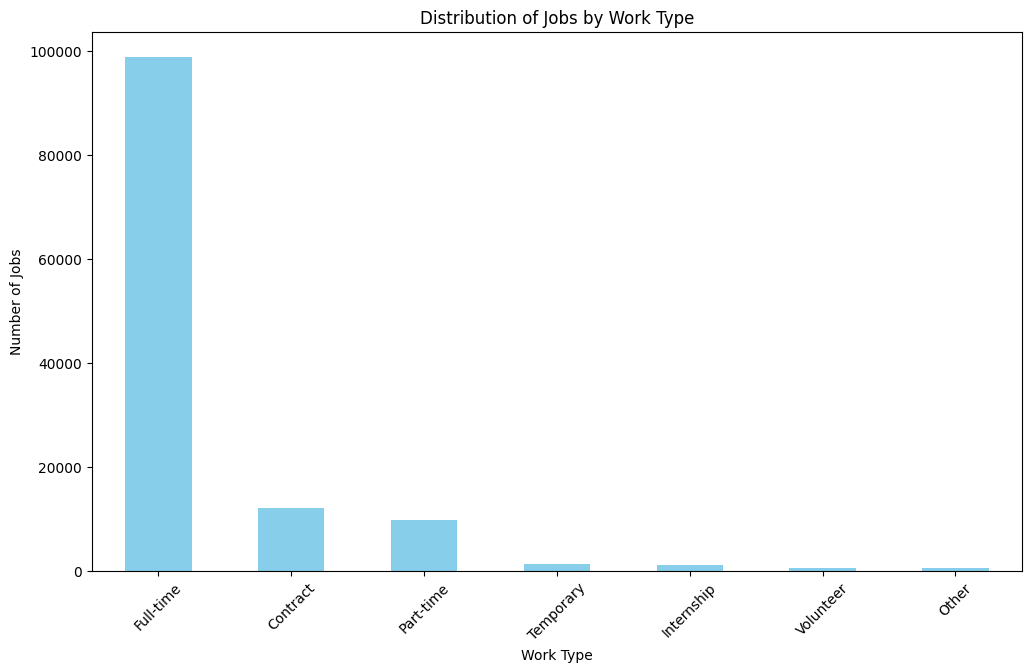

In [ ]:
# Distribution of jobs by work type
work_type_distribution = comprehensive_data_one_to_one['formatted_work_type'].value_counts()

# Plot
plt.figure(figsize=(12, 7))
work_type_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Jobs by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)
plt.show()

**Full-time positions** dominate the job postings, making up the vast majority.
*Part-time and Temporary positions* are considerably less common in comparison.
***Contract, Internship, and other types of positions*** are even less frequent.


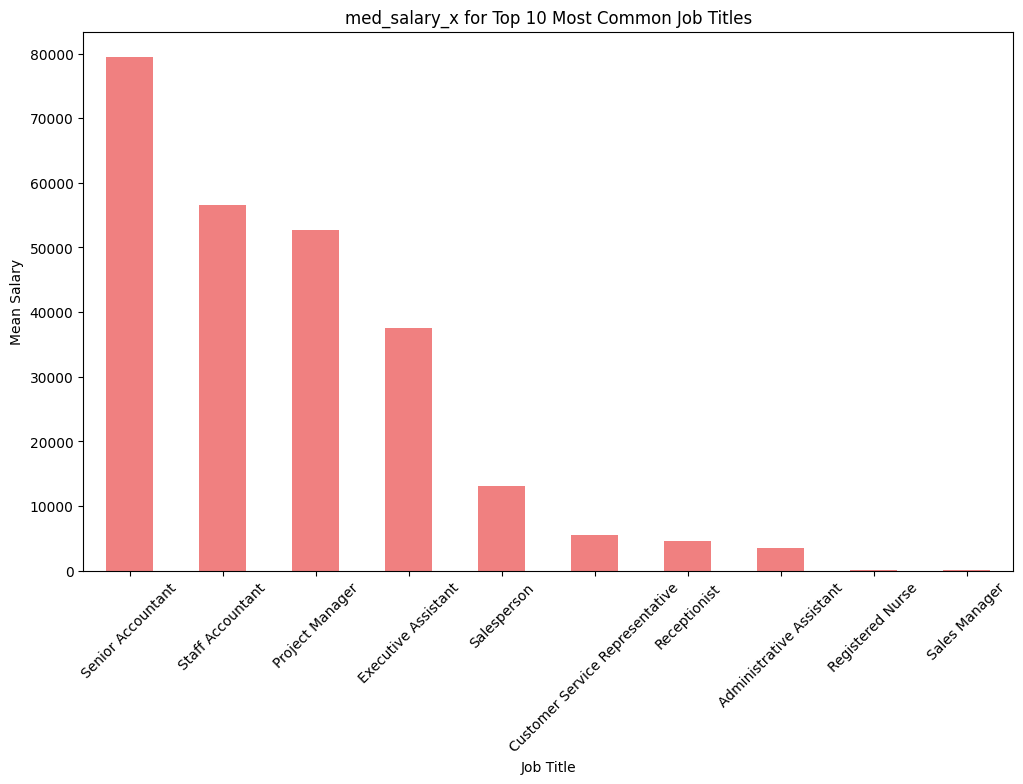

In [ ]:
# Filtering top 10 most common job titles
top_titles = comprehensive_data_one_to_one['title'].value_counts().index[:10]

# Filtering data for these titles
top_titles_data = comprehensive_data_one_to_one[comprehensive_data_one_to_one['title'].isin(top_titles)]

# Grouping by title and calculating median salary
median_salaries = top_titles_data.groupby('title')['med_salary_x'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 7))
median_salaries.plot(kind='bar', color='lightcoral')
plt.title('med_salary_x for Top 10 Most Common Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Mean Salary')
plt.xticks(rotation=45)
plt.show()

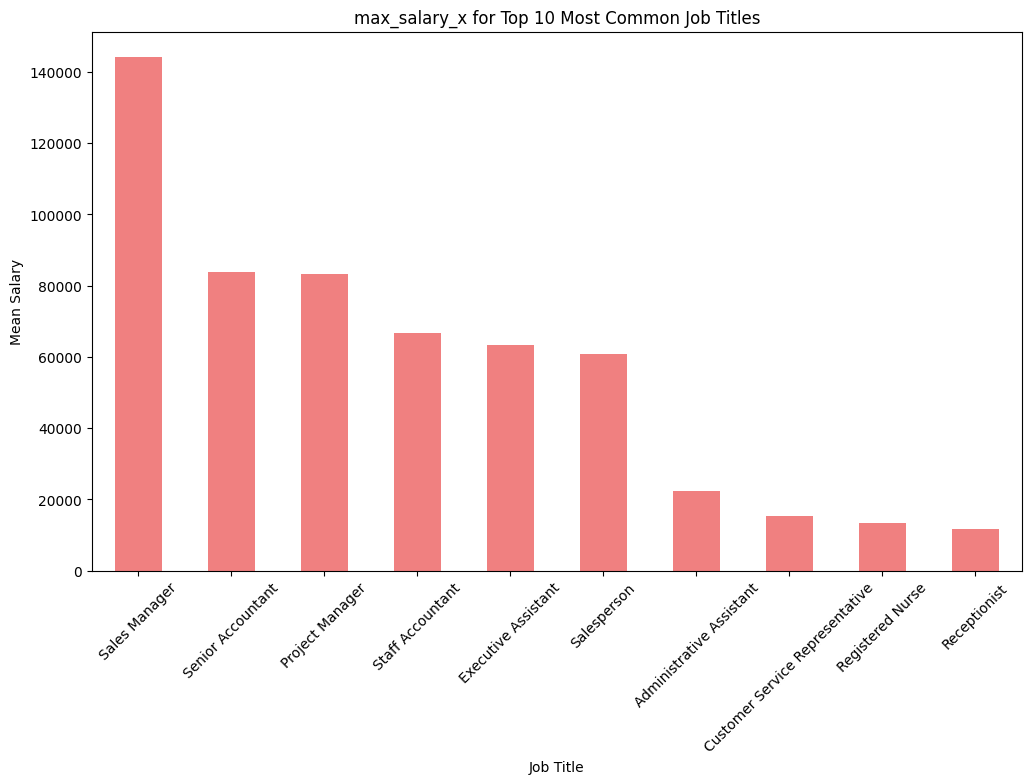

In [ ]:
# Filtering top 10 most common job titles
top_titles = comprehensive_data_one_to_one['title'].value_counts().index[:10]

# Filtering data for these titles
top_titles_data = comprehensive_data_one_to_one[comprehensive_data_one_to_one['title'].isin(top_titles)]

# Grouping by title and calculating median salary
median_salaries = top_titles_data.groupby('title')['max_salary_x'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 7))
median_salaries.plot(kind='bar', color='lightcoral')
plt.title('max_salary_x for Top 10 Most Common Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Mean Salary')
plt.xticks(rotation=45)
plt.show()

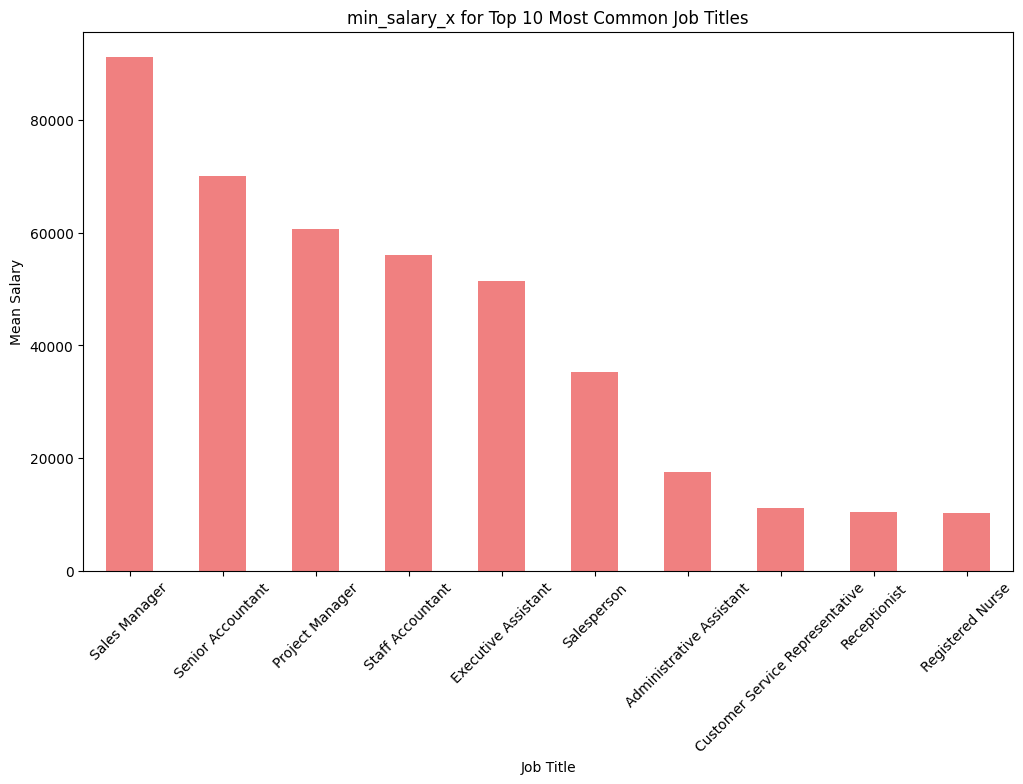

In [ ]:
# Filtering top 10 most common job titles
top_titles = comprehensive_data_one_to_one['title'].value_counts().index[:10]

# Filtering data for these titles
top_titles_data = comprehensive_data_one_to_one[comprehensive_data_one_to_one['title'].isin(top_titles)]

# Grouping by title and calculating median salary
median_salaries = top_titles_data.groupby('title')['min_salary_x'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 7))
median_salaries.plot(kind='bar', color='lightcoral')
plt.title('min_salary_x for Top 10 Most Common Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Mean Salary')
plt.xticks(rotation=45)
plt.show()

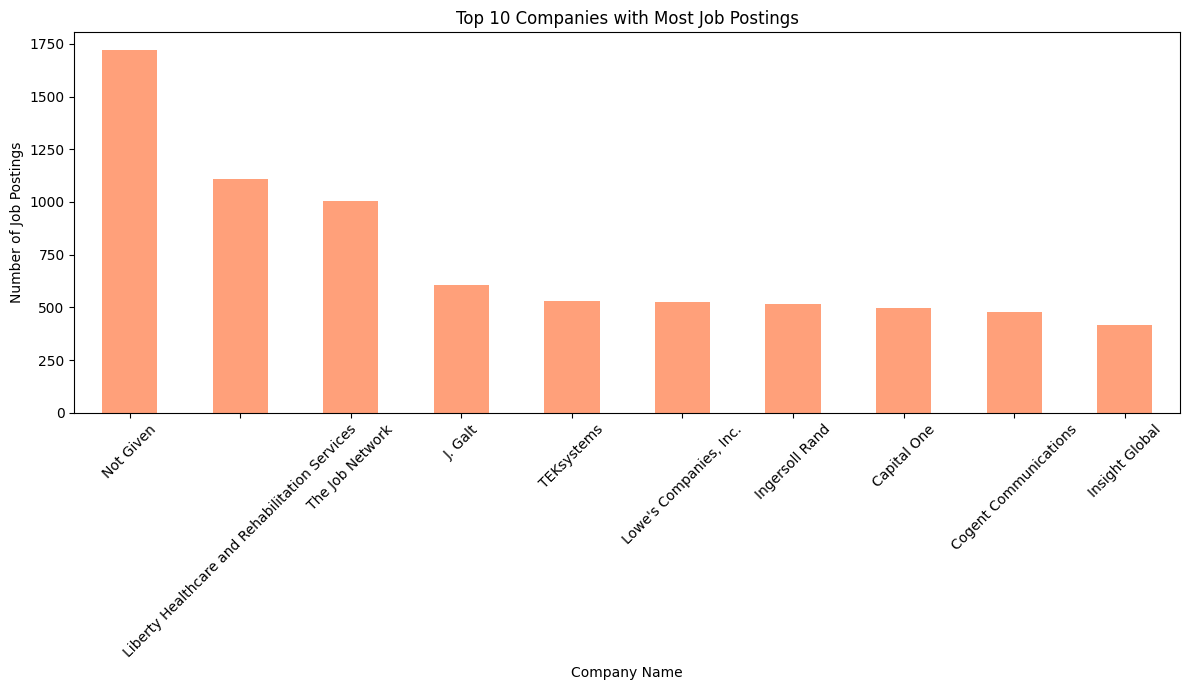

In [ ]:
# Top companies with the most job postings
top_companies = comprehensive_data_one_to_one['name'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 7))
top_companies.plot(kind='bar', color='lightsalmon')
plt.title('Top 10 Companies with Most Job Postings')
plt.xlabel('Company Name')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

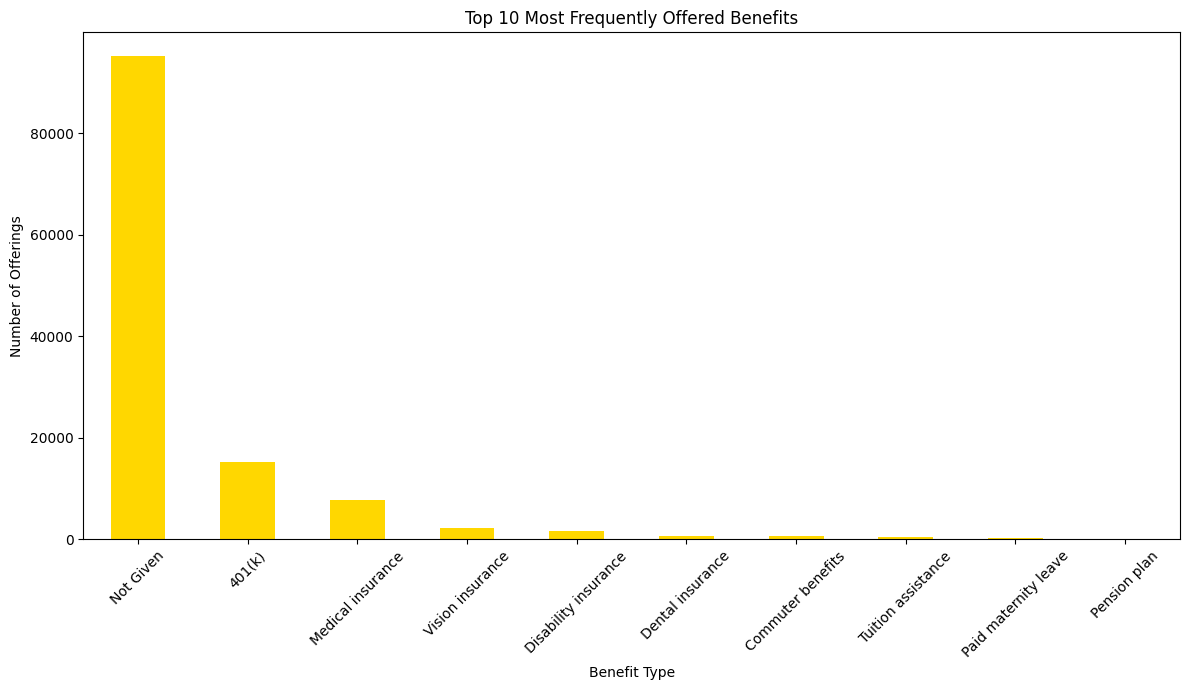

In [ ]:
# Most frequently offered benefits
top_benefits = comprehensive_data_one_to_one['type'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 7))
top_benefits.plot(kind='bar', color='gold')
plt.title('Top 10 Most Frequently Offered Benefits')
plt.xlabel('Benefit Type')
plt.ylabel('Number of Offerings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

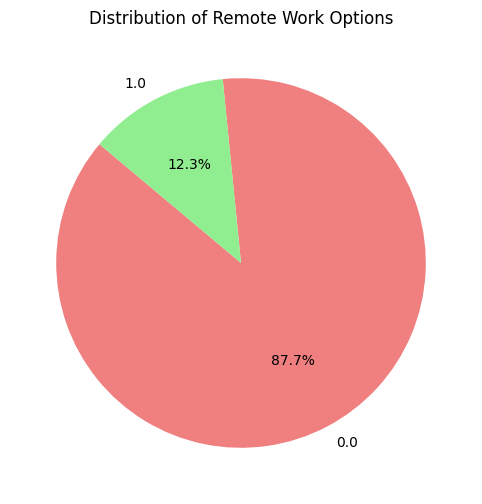

In [ ]:
# Distribution of remote work options
remote_work_distribution = comprehensive_data_one_to_one['remote_allowed'].value_counts()

# Plot
plt.figure(figsize=(9, 6))
remote_work_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightgreen', 'lightblue'])
plt.title('Distribution of Remote Work Options')
plt.ylabel('')
plt.show()

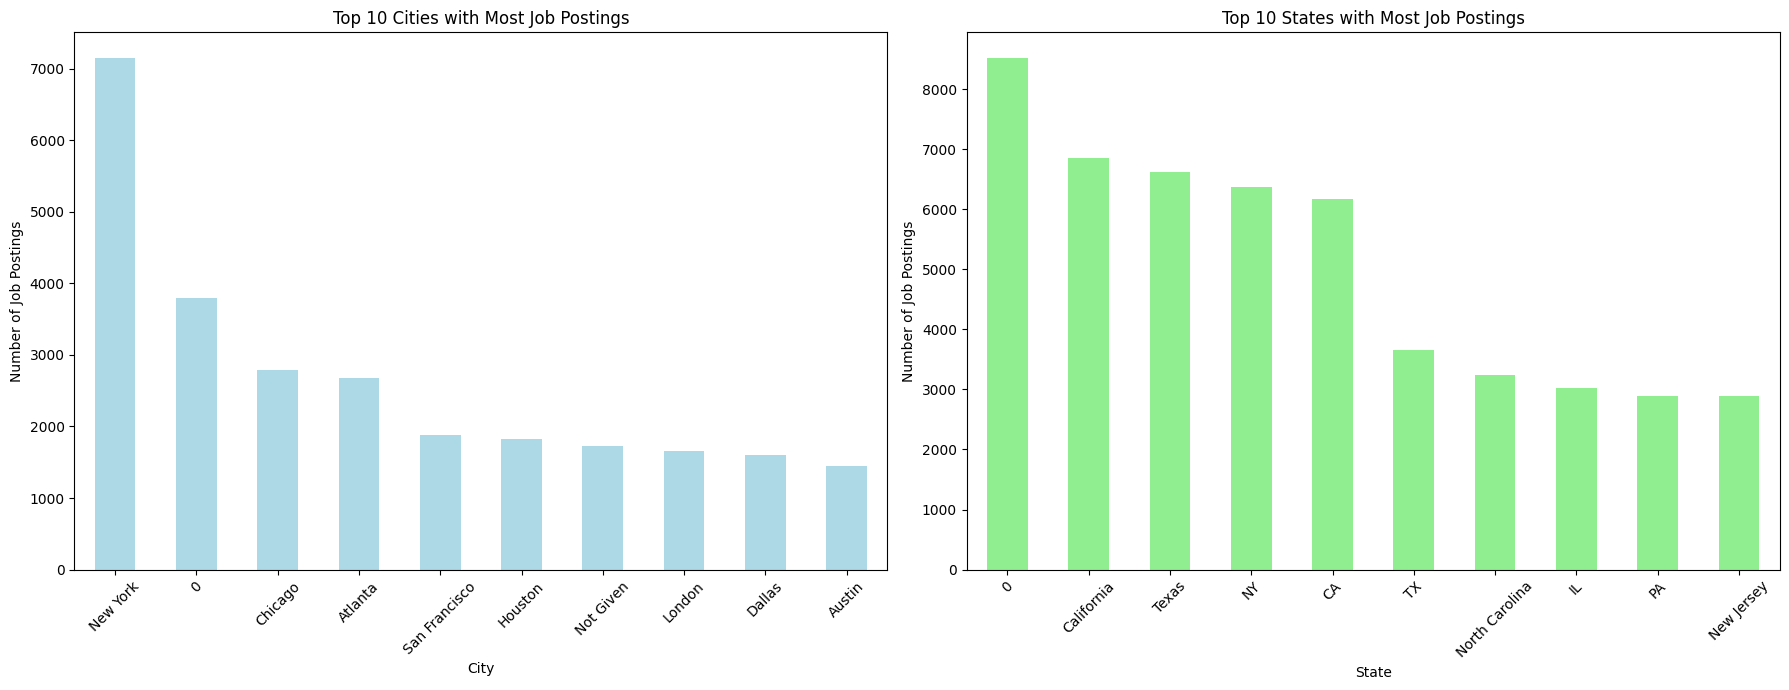

In [ ]:
# Top cities with the most job postings
top_cities = comprehensive_data_one_to_one['city'].value_counts().head(10)

# Top states with the most job postings
top_states = comprehensive_data_one_to_one['state'].value_counts().head(10)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Cities
top_cities.plot(kind='bar', color='lightblue', ax=ax1)
ax1.set_title('Top 10 Cities with Most Job Postings')
ax1.set_xlabel('City')
ax1.set_ylabel('Number of Job Postings')
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# States
top_states.plot(kind='bar', color='lightgreen', ax=ax2)
ax2.set_title('Top 10 States with Most Job Postings')
ax2.set_xlabel('State')
ax2.set_ylabel('Number of Job Postings')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

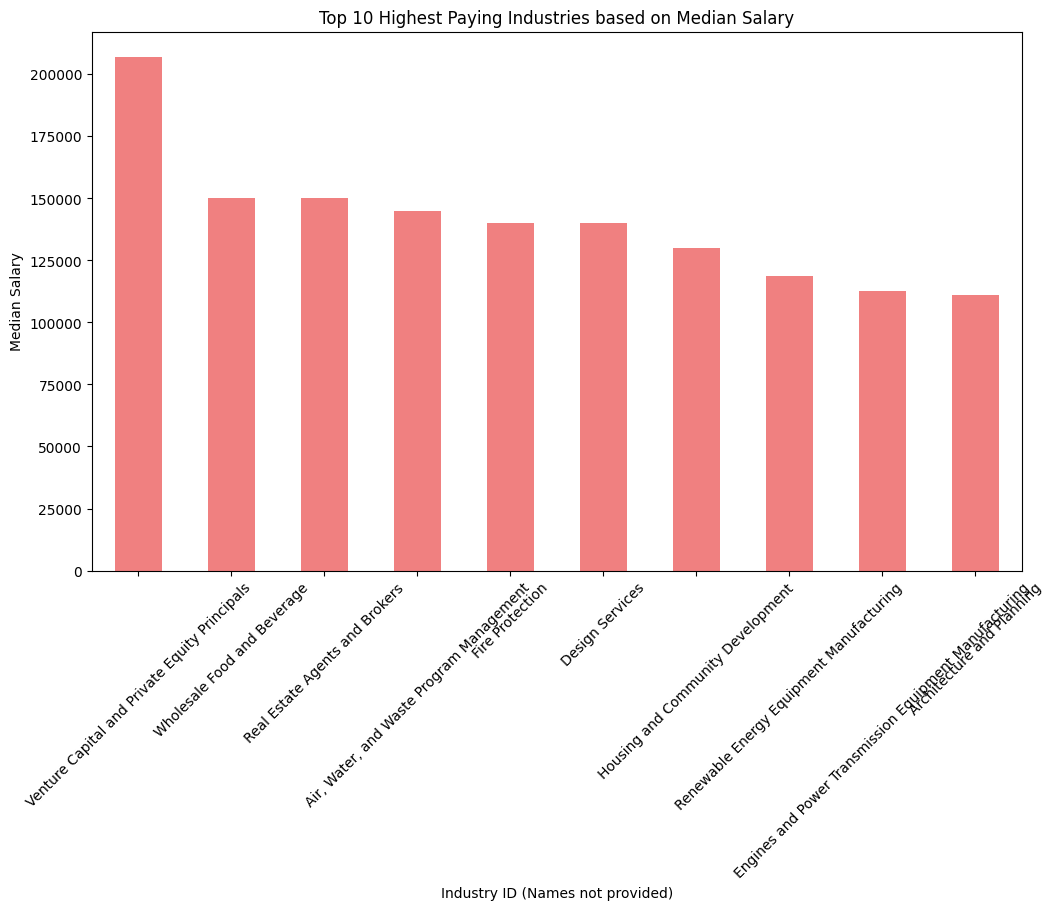

In [ ]:
# Merging job_industries with the main dataset to get the salary information
merged_with_industries = pd.merge(comprehensive_data_one_to_one, job_industries, on='job_id', how='left')

# Calculating median salaries for each industry
industry_salaries = merged_with_industries.groupby('industry_name')['med_salary_x'].mean().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 7))
industry_salaries.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Highest Paying Industries based on Median Salary')
plt.xlabel('Industry ID (Names not provided)')
plt.ylabel('Median Salary')
plt.xticks(rotation=45)
plt.show()


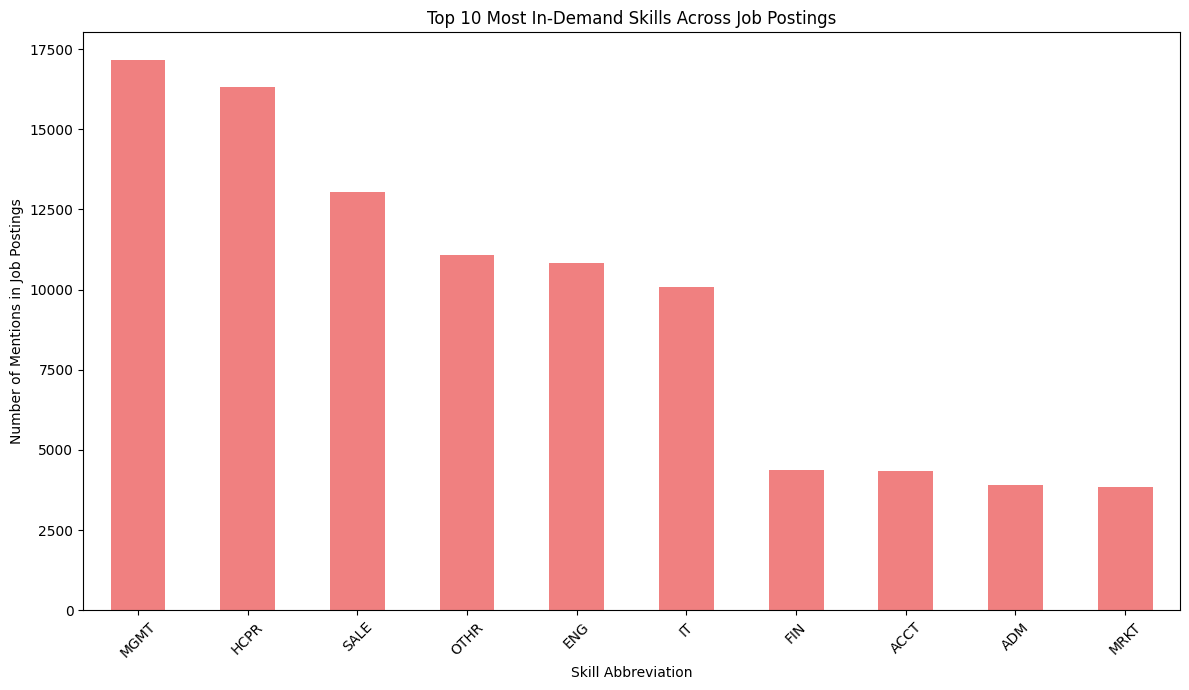

In [ ]:
# Most in-demand skills across job postings using the correct column
top_skills = comprehensive_data_one_to_one['skill_abr'].value_counts().head(10)

# Plotting
plt.figure(figsize=(12, 7))
top_skills.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Most In-Demand Skills Across Job Postings')
plt.xlabel('Skill Abbreviation')
plt.ylabel('Number of Mentions in Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

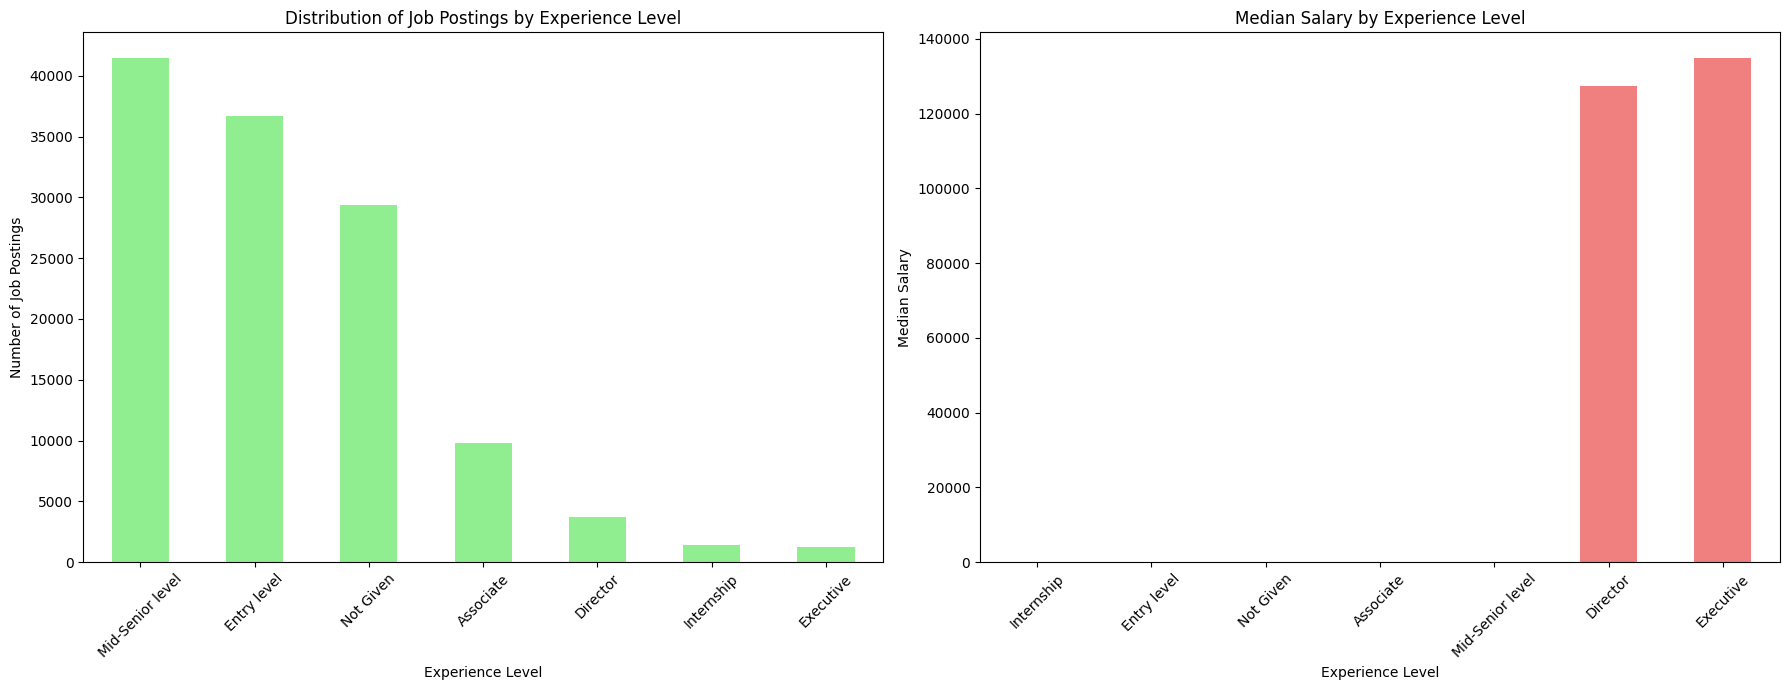

In [ ]:
# Distribution of job postings by experience level
experience_level_distribution = comprehensive_data_one_to_one['formatted_experience_level'].value_counts()

# Median salary by experience level
median_salary_by_experience = comprehensive_data_one_to_one.groupby('formatted_experience_level')['med_salary_x'].median()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Experience Level Distribution
experience_level_distribution.plot(kind='bar', color='lightgreen', ax=ax1)
ax1.set_title('Distribution of Job Postings by Experience Level')
ax1.set_xlabel('Experience Level')
ax1.set_ylabel('Number of Job Postings')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Median Salary by Experience Level
median_salary_by_experience.sort_values().plot(kind='bar', color='lightcoral', ax=ax2)
ax2.set_title('Median Salary by Experience Level')
ax2.set_xlabel('Experience Level')
ax2.set_ylabel('Median Salary')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
comprehensive_data_one_to_one.shape

(123849, 55)

In [ ]:
comprehensive_data_one_to_one.industry_name.value_counts().head(10)

industry_name
Hospitals and Health Care        16214
Retail                            8736
Staffing and Recruiting           8085
IT Services and IT Consulting     7964
Financial Services                5977
Software Development              4107
Construction                      2670
Manufacturing                     2479
Real Estate                       2091
Banking                           2002
Name: count, dtype: int64

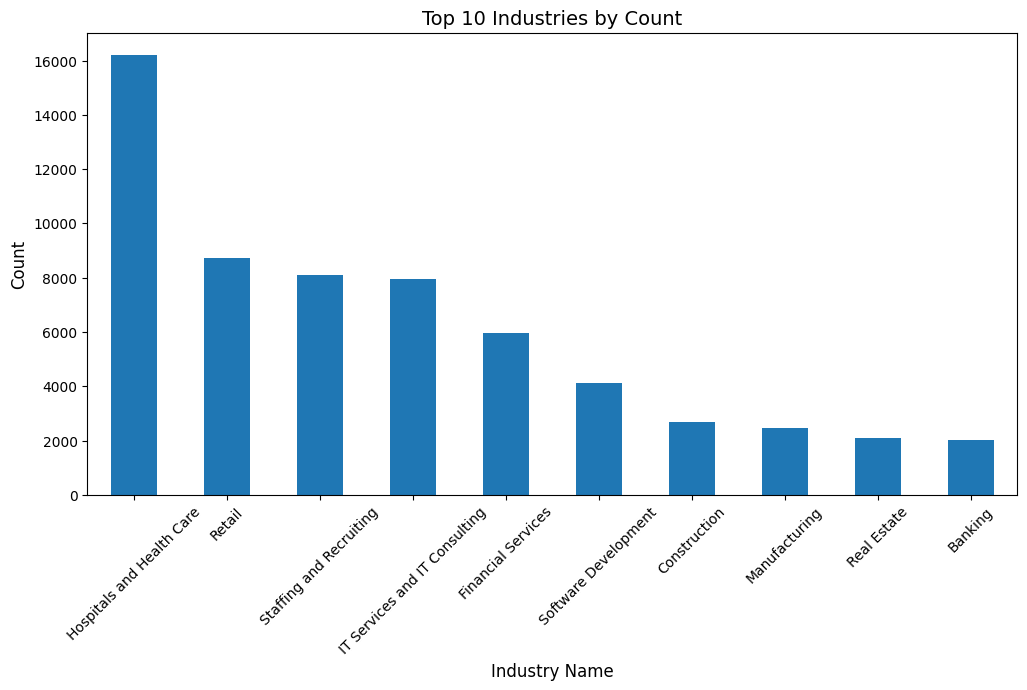

In [ ]:
import matplotlib.pyplot as plt

# Get the data
data = comprehensive_data_one_to_one.industry_name.value_counts().head(10)

# Prepare the plot
plt.figure(figsize=(12, 6))

# Plot the data
data.plot(kind='bar')

# Add labels and title
plt.xlabel("Industry Name", size=12)
plt.ylabel("Count", size=12)
plt.title("Top 10 Industries by Count", size=14)
plt.xticks(rotation=45)
# Show the plot
plt.show()

# Feature Extraction (Like Article) (Not Achieved)

In [ ]:
comprehensive_data_one_to_one.columns

Index(['job_id', 'company_name', 'title', 'description_x', 'max_salary_x',
       'pay_period_x', 'location', 'company_id', 'views', 'med_salary_x',
       'min_salary_x', 'formatted_work_type', 'applies',
       'original_listed_time', 'remote_allowed', 'job_posting_url',
       'application_url', 'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency_x',
       'compensation_type_x', 'inferred', 'type', 'industry_id', 'skill_abr',
       'salary_id', 'max_salary_y', 'med_salary_y', 'min_salary_y',
       'pay_period_y', 'currency_y', 'compensation_type_y', 'industry_name',
       'skill_name', 'name', 'description_y', 'company_size', 'state',
       'country', 'city', 'zip_code', 'address', 'url', 'employee_count',
       'follower_count', 'time_recorded', 'industry', 'speciality'],
      dtype='object')

In [ ]:
df = comprehensive_data_one_to_one.copy()

In [ ]:


# Assuming 'company_name' and 'industry_name' are the columns that contain the relevant data
# Filter the top 10,000 employers based on a column, say 'views' or another relevance metric
df_top_employers = df.nlargest(10000, 'views')

# Function to classify into Positive or Negative class based on industry
def classify_employer(row, industry):
    return 'Positive' if row['industry_name'] == industry else 'Negative'

# Apply the classification for both Transportation and Health Care
df_top_employers['class_transportation'] = df_top_employers.apply(classify_employer, axis=1, args=('Retail',))
df_top_employers['class_health_care'] = df_top_employers.apply(classify_employer, axis=1, args=('Hospitals and Health Care',))


In [ ]:
# Split the data for the Transportation industry
X_train_trans, X_temp_trans, y_train_trans, y_temp_trans = train_test_split(
    df_top_employers[['company_name', 'description_x', 'skills_desc']],
    df_top_employers['class_transportation'],
    test_size=0.30,
    stratify=df_top_employers['class_transportation']
)

X_val_trans, X_test_trans, y_val_trans, y_test_trans = train_test_split(
    X_temp_trans,
    y_temp_trans,
    test_size=(2/3),
    stratify=y_temp_trans
)

# Split the data for the Health Care industry
X_train_health, X_temp_health, y_train_health, y_temp_health = train_test_split(
    df_top_employers[['company_name', 'description_x', 'skills_desc']],
    df_top_employers['class_health_care'],
    test_size=0.30,
    stratify=df_top_employers['class_health_care']
)

X_val_health, X_test_health, y_val_health, y_test_health = train_test_split(
    X_temp_health,
    y_temp_health,
    test_size=(2/3),
    stratify=y_temp_health
)


In [ ]:
# Resample the training data for the Transportation industry
df_train_trans = pd.concat([X_train_trans, y_train_trans], axis=1)
df_majority_trans = df_train_trans[df_train_trans.class_transportation == 'Negative']
df_minority_trans = df_train_trans[df_train_trans.class_transportation == 'Positive']

df_minority_upsampled_trans = resample(df_minority_trans,
                                       replace=True,
                                       n_samples=len(df_majority_trans),
                                       random_state=123)

df_upsampled_trans = pd.concat([df_majority_trans, df_minority_upsampled_trans])
X_train_trans_upsampled = df_upsampled_trans[['company_name', 'description_x', 'skills_desc']]
y_train_trans_upsampled = df_upsampled_trans['class_transportation']


In [ ]:
# Assuming the 'industry_name' column in your DataFrame indicates the actual industry of each employer
def generate_class_column(df, industry_target):
    # Mark employers in the target industry as Positive Class, others as Negative Class
    df['class'] = df['industry_name'].apply(lambda x: 1 if x == industry_target else 0)
    return df

# Apply this function to both Transportation and Health Care datasets
data_trans = generate_class_column(data_trans, 'Retail')
data_health = generate_class_column(data_health, 'Hospitals and Health Care')

# Now continue with your data split from earlier
train_trans, test_trans = train_test_split(data_trans, test_size=0.3, random_state=42)
val_trans, test_trans = train_test_split(test_trans, test_size=0.67, random_state=42)  # 10% validation, 20% test

train_health, test_health = train_test_split(data_health, test_size=0.3, random_state=42)
val_health, test_health = train_test_split(test_health, test_size=0.67, random_state=42)


In [ ]:
data_trans["class"].value_counts()

class
0    8736
Name: count, dtype: int64

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Simulate loading data (replace with actual file loading if applicable)
data = comprehensive_data_one_to_one.copy()
data = data.nlargest(10000, 'views')
# Assuming data contains an 'industry' column with 'Transportation' and 'Health Care' as values
# Filter data for Transportation and Health Care industries only


def generate_class_column(df, industry_target):
    # Mark employers in the target industry as Positive Class, others as Negative Class
    df['class'] = df['industry_name'].apply(lambda x: 1 if x == industry_target else 0)
    return df

# Apply this function to both Transportation and Health Care datasets
data_trans = generate_class_column(data, 'Retail')
data_health = generate_class_column(data, 'Hospitals and Health Care')



# Split data into train, validation, and test sets
train_trans, test_trans = train_test_split(data_trans, test_size=0.3, random_state=42)
# val_trans, test_trans = train_test_split(test_trans, test_size=0.67, random_state=42)  # 10% validation, 20% test

train_health, test_health = train_test_split(data_health, test_size=0.3, random_state=42)
# val_health, test_health = train_test_split(test_health, test_size=0.67, random_state=42)


In [ ]:
def create_features(df, title_col='title', employer_col='company_name'):
    # Dummy function to extract features - implement based on actual requirements
    df['title_feature'] = df[title_col].apply(lambda x: len(x))  # Example feature: length of job title
    df['name_feature'] = df[employer_col].apply(lambda x: x.count(' '))  # Count spaces as a proxy for name complexity
    return df

train_trans = create_features(train_trans)
#val_trans = create_features(val_trans)
test_trans = create_features(test_trans)

train_health = create_features(train_health)
#val_health = create_features(val_health)
test_health = create_features(test_health)


In [ ]:
train_trans['title_feature']

6749199     25
237727      27
6875363     36
6798258     59
7320373     17
            ..
10353202    22
9110898     15
25824       33
1213530     19
10524438    42
Name: title_feature, Length: 86694, dtype: int64

In [ ]:
train_trans["class"].value_counts()

class
0    75247
1    11447
Name: count, dtype: int64

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return precision, recall, f1

# Select features and target
features = ['title_feature', 'name_feature']
target = 'class'  # Assume there's a 'class' column indicating Positive or Negative Class

# SVM Model
svm_model_trans = SVC(kernel='linear', class_weight='balanced')  # Use balanced class weight for handling imbalance
svm_precision_trans, svm_recall_trans, svm_f1_trans = train_and_evaluate(
    svm_model_trans, train_trans[features], train_trans[target], test_trans[features], test_trans[target]
)

# GBDT Model
gbdt_model_trans = GradientBoostingClassifier()
gbdt_precision_trans, gbdt_recall_trans, gbdt_f1_trans = train_and_evaluate(
    gbdt_model_trans, train_trans[features], train_trans[target], test_trans[features], test_trans[target]
)

# Repeat the process for the Health Care industry
svm_model_health = SVC(kernel='linear', class_weight='balanced')
svm_precision_health, svm_recall_health, svm_f1_health = train_and_evaluate(
    svm_model_health, train_health[features], train_health[target], test_health[features], test_health[target]
)

gbdt_model_health = GradientBoostingClassifier()
gbdt_precision_health, gbdt_recall_health, gbdt_f1_health = train_and_evaluate(
    gbdt_model_health, train_health[features], train_health[target], test_health[features], test_health[target]
)


In [ ]:
print("Transportation Industry SVM: Precision=\t", svm_precision_trans, "\tRecall=", svm_recall_trans, "\tF1=", svm_f1_trans)
print("Transportation Industry GBDT: Precision=", gbdt_precision_trans, "\tRecall=", gbdt_recall_trans, "\tF1=", gbdt_f1_trans)
print("Health Care Industry SVM: Precision=\t", svm_precision_health, "\tRecall=", svm_recall_health, "\tF1=", svm_f1_health)
print("Health Care Industry GBDT: Precision=\t", gbdt_precision_health, "\tRecall=", gbdt_recall_health, "\tF1=", gbdt_f1_health)


Transportation Industry SVM: Precision=	 0.2059282371294852 	Recall= 0.4553151458137347 	F1= 0.28359375
Transportation Industry GBDT: Precision= 0.6455223880597015 	Recall= 0.05424898087174663 	F1= 0.10008678044547294
Health Care Industry SVM: Precision=	 0.2059282371294852 	Recall= 0.4553151458137347 	F1= 0.28359375
Health Care Industry GBDT: Precision=	 0.6455223880597015 	Recall= 0.05424898087174663 	F1= 0.10008678044547294


# Further Experiments Independent From Article



## Explanation
## 1. Pipeline
A pipeline in machine learning is essentially a way to streamline a sequence of data processing steps and modeling into a single object. This helps in simplifying the code and ensuring that the same sequence of steps is applied both during training and when making predictions. It's especially useful for ensuring that transformations like feature scaling or vectorization are performed consistently before applying a model.

**In the context of scikit-learn**:

Pipeline encapsulates a sequence of transformations followed by a final estimator. Each step is a tuple containing a name and an object that implements the fit and transform methods. The last object in the pipeline only needs to implement fit. The pipeline offers the same API as a regular classifier or regressor: you can fit it to training data and use it to predict on new data.
## 2. TfidfVectorizer
TfidfVectorizer is a feature extraction tool from the scikit-learn library that transforms text into a more manageable form for machine learning models. It stands for "Term Frequency-Inverse Document Frequency", a numerical statistic that reflects how important a word is to a document in a collection or corpus.

**Here’s what it does**:

**Term Frequency (TF)**: Measures how frequently a term occurs in a document. In the vectorization process, this counts the number of times a term t appears in a document divided by the total number of terms in the document.

**Inverse Document Frequency (IDF)**: This measures how important a term is. While computing TF, all terms are considered equally important. However, certain terms, like "is", "of", and "that", may appear a lot of times but have little importance. Thus, we need to weigh down the frequent terms while scale up the rare ones, by computing the following:


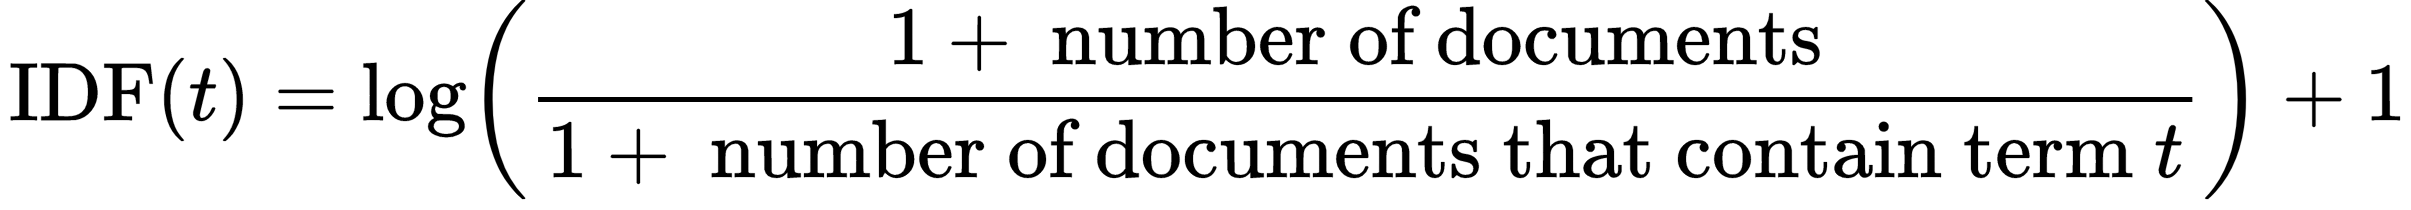


**Vectorizer**: This component converts text data into a sparse matrix of TF-IDF features.


Effectively, TfidfVectorizer turns a collection of text documents into a matrix of token counts and tf-idf features, which can be fed into machine learning algorithms like logistic regression for classification.

## 3. Logistic Regression
Logistic Regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In the context of machine learning, logistic regression is used for binary classification tasks (yes/no, true/false, 1/0).

**Characteristics include**:

**Output**: The output of logistic regression is a probability that the given input point belongs to a certain class, which is converted to a binary outcome via a threshold usually set at 0.5.


**Modeling**: The probabilities describing the possible outcomes of a single trial are modeled using a logistic function, which outputs values between 0 and 1. The model predicts the probability of the target class based on the input features.


**Parameters**: The logistic regression model has parameters (like weights in linear regression) that are adjusted to best fit the model to the training data by maximizing the likelihood of the observed sequence of labels.



By using these components in a pipeline, you ensure that the textual data is properly transformed into a format suitable for model training and that the logistic regression model can be trained on this data directly. This setup not only minimizes the code but also avoids mistakes like leaking data during cross-validation by ensuring that feature extraction and model training are contained within each fold of the cross-validation.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline

# Load data
df = comprehensive_data_one_to_one.copy()

# Step 1: Data Preparation
# Create a binary target variable: 1 if 'Hospitals and Health Care', 0 otherwise
df['is_healthcare'] = (df['industry_name'] == 'Hospitals and Health Care').astype(int)

# Combine text data into a single column
df['text_data'] = df['title'] + ' ' + df['description_x']

# Handle missing values if necessary
df['text_data'].fillna('', inplace=True)

# Step 2: Feature Engineering and Model Building
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_data'], df['is_healthcare'], test_size=0.2, random_state=42)

# Create a text processing and classification pipeline
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    LogisticRegression(random_state=42)
)

# Train the model
pipeline.fit(X_train, y_train)

# Step 3: Evaluation
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Print the accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.9682276947920873
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     21573
           1       0.92      0.83      0.87      3197

    accuracy                           0.97     24770
   macro avg       0.95      0.91      0.93     24770
weighted avg       0.97      0.97      0.97     24770



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline


df = comprehensive_data_one_to_one.copy()

# Step 1: Data Preparation
# Create a binary target variable: 1 if 'Retail', 0 otherwise
df['is_Retail'] = (df['industry_name'] == 'Retail').astype(int)

# Combine text data into a single column
df['text_data'] = df['title'] + ' ' + df['description_x']

# Handle missing values if necessary
df['text_data'].fillna('', inplace=True)

# Step 2: Feature Engineering and Model Building
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_data'], df['is_Retail'], test_size=0.2, random_state=42)

# Create a text processing and classification pipeline
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    LogisticRegression(random_state=42)
)

# Train the model
pipeline.fit(X_train, y_train)

# Step 3: Evaluation
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Print the accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.98675817521195
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23024
           1       0.95      0.86      0.90      1746

    accuracy                           0.99     24770
   macro avg       0.97      0.93      0.95     24770
weighted avg       0.99      0.99      0.99     24770



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Assuming 'df' is already loaded into your environment

# Step 1: Filter the data to include only the top 10 industries
top_10_industries = df['industry_name'].value_counts().nlargest(10).index
df_top_10 = df[df['industry_name'].isin(top_10_industries)]

# Step 2: Data Preparation
# Combine text data into a single column
df_top_10['text_data'] = df_top_10['title'] + ' ' + df_top_10['description_x']

# Handle missing values
df_top_10['text_data'].fillna('', inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_top_10['text_data'], df_top_10['industry_name'], test_size=0.2, random_state=42)

# Step 3: Pipeline Creation
# Create a text processing and classification pipeline
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
)

# Step 4: Model Training
pipeline.fit(X_train, y_train)

# Step 5: Evaluation
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


<ipython-input-145-05554b36cc3f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['text_data'] = df_top_10['title'] + ' ' + df_top_10['description_x']
<ipython-input-145-05554b36cc3f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['text_data'].fillna('', inplace=True)


Classification Report:
                                precision    recall  f1-score   support

                      Banking       0.88      0.74      0.81       388
                 Construction       0.81      0.86      0.83       505
           Financial Services       0.85      0.81      0.83      1261
    Hospitals and Health Care       0.94      0.96      0.95      3220
IT Services and IT Consulting       0.70      0.85      0.77      1645
                Manufacturing       0.80      0.71      0.75       516
                  Real Estate       0.92      0.78      0.84       427
                       Retail       0.95      0.95      0.95      1685
         Software Development       0.80      0.71      0.75       824
      Staffing and Recruiting       0.80      0.76      0.78      1594

                     accuracy                           0.85     12065
                    macro avg       0.85      0.81      0.83     12065
                 weighted avg       0.86      0.85 

# **Feature Goals**

## **For Feature Extraction From String**


**CountVectorizer**: This tool simply counts the number of times each word appears in the document. Unlike TfidfVectorizer, it does not consider the importance of a word across all documents (IDF). It’s useful when the frequency of the word itself is a strong indicator of its relevance.

**HashingVectorizer**: This is another method for converting text documents into a matrix of token occurrences. It is memory efficient because it doesn't store the vocabulary; instead, it uses a hashing trick to convert terms into matrix indices. It's particularly useful when dealing with large datasets, as it does not require fitting and is stateless.

**Word2Vec**: Moving beyond frequency-based methods, Word2Vec provides an embedding for each word, capturing more context and semantic meaning. This model uses neural networks to learn word associations from a large corpus of text and can capture complex word relationships.

**Doc2Vec**: An extension of Word2Vec, Doc2Vec provides a way to convert entire documents into vectors. It also learns to predict the context within documents, making it suitable for tasks involving document similarity and clustering.

**BERT Embeddings**: Developed by Google, BERT (Bidirectional Encoder Representations from Transformers) provides a powerful method for creating contextually rich word embeddings. It's highly effective for tasks that require understanding the meaning of text within context, such as sentiment analysis and question answering.

## **Alternative Models For Classification**

**Linear Discriminant Analysis (LDA)**: This is a classifier with a linear decision boundary, generated by fitting class conditional densities to the data using Bayes’ rule. It assumes that the data are Gaussian and that the classes have identical covariance matrices.

**Support Vector Machines (SVM)**: SVM is particularly effective in high-dimensional spaces and is versatile in that it can be used for both linear and non-linear classification (using kernel functions). It works by finding the hyperplane that best divides a dataset into classes.

**Decision Trees**: These are non-linear models that divide the feature space into regions by making sequential, hierarchical decisions about the input features. Trees are easy to understand and interpret but can be prone to overfitting.

**Random Forests**: An ensemble of decision trees, typically trained via the bagging method. Random forests are very effective and robust against overfitting as they combine many trees to reduce variance without increasing bias.

**Gradient Boosting Machines (GBM)**: Another ensemble technique that builds trees in a sequential manner, where each new tree helps to correct errors made by the previously trained tree. GBM can be used for both regression and classification problems.

**Neural Networks**: These are powerful models that can capture complex relationships in data through layers of neurons and can be used for both regression and classification. They are particularly useful for large datasets and can model non-linear interactions between variables.

**Naive Bayes**: A group of probabilistic classifiers based on Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable. Naive Bayes classifiers are extremely fast and suitable for very large datasets.
